<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<div style="text-align: center;">
<img src="../Imagenes/CUGDL_logo.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 5. Validación y control de sobreajuste: validación cruzada</span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iván A. Toledano Juárez </span>  </center>

# División de datos y validación cruzada con regresión lineal

## Introducción

Hasta ahora, hemos aprendido a construir modelos de regresión lineal simple y múltiple para predecir variables continuas a partir de un conjunto de características. Sin embargo, un aspecto fundamental del aprendizaje automático supervisado no es solo construir el modelo, sino **evaluarlo correctamente**.

En esta unidad exploraremos técnicas para **validar el desempeño de un modelo** de manera más robusta, evitando uno de los errores más comunes: **evaluar sobre los mismos datos de entrenamiento**, lo que puede llevar a un fenómeno conocido como **sobreajuste (overfitting)**.

A lo largo de este notebook aprenderás a:
- Dividir adecuadamente un conjunto de datos en entrenamiento y prueba,
- Detectar señales de sobreajuste,
- Implementar y comparar esquemas de evaluación como la **validación cruzada**.

Para ilustrar estos conceptos utilizaremos el dataset **California Housing**, disponible en `scikit-learn`. Este conjunto de datos contiene información socioeconómica y de vivienda agregada por bloques censales del estado de California, incluyendo variables como la densidad poblacional, el número promedio de habitaciones o el ingreso medio por hogar, con el objetivo de predecir el **valor promedio de las viviendas** en cada zona.

---

## ¿Por qué dividir nuestros datos? El problema del sobreajuste

Antes de evaluar un modelo, es importante entender una de las principales razones por las que una evaluación puede ser engañosa: **el sobreajuste**. Cuando un modelo se ajusta demasiado a los datos de entrenamiento, puede aprender no solo los patrones relevantes, sino también el ruido o las particularidades de ese conjunto, perdiendo capacidad de generalización. Esto lleva a resultados aparentemente buenos durante el entrenamiento, pero con **mal desempeño en datos nuevos o desconocidos**.

Para evitarlo, una buena práctica es **reservar parte del conjunto de datos** para evaluar el modelo de manera menos sesgada. Más adelante, también veremos cómo la validación cruzada puede mejorar aún más esta estimación del rendimiento.

---

In [1]:
# Importacíon de librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_val_score

## Importación y revisión de datos

In [2]:
# El dataset ya viene dentro de scikit-learn
data = fetch_california_housing(as_frame=True)

# Los datos que vienen en scikit-learn ya tienen implementado atributos de la matriz de características y el target
X = data.data
y = data.target
df_calhs = pd.concat([X, y.rename("MedHouseVal")], axis=1)
df_calhs.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
# Info del dataset
df_calhs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
# Estadísticas básicas
df_calhs.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


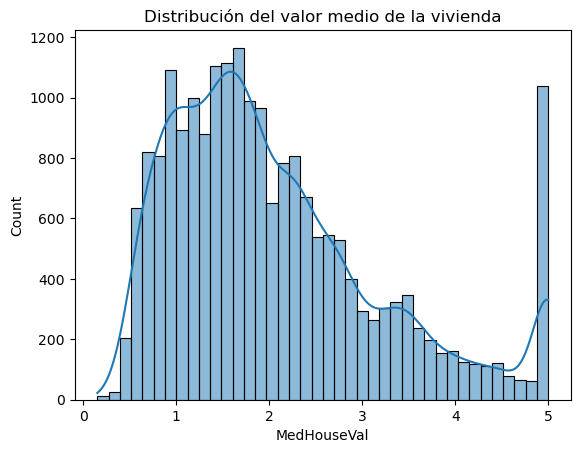

In [5]:
# Histograma de la variable objetivo
sns.histplot(df_calhs["MedHouseVal"], bins=40, kde=True)
plt.title("Distribución del valor medio de la vivienda")
plt.xlabel("MedHouseVal")
plt.show()

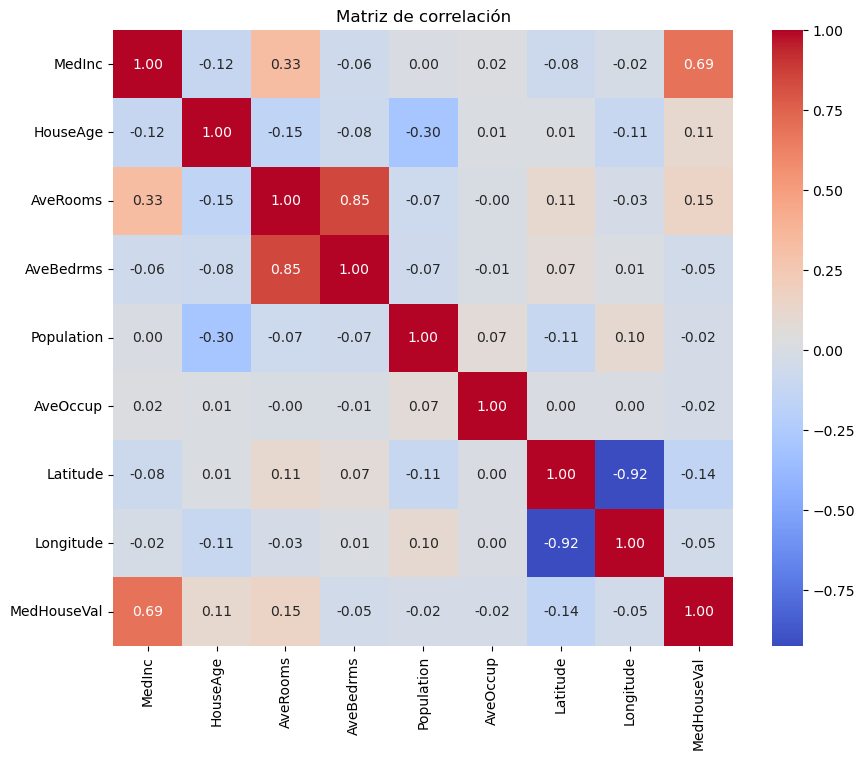

In [6]:
# Mapa de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(df_calhs.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

## Entrenar y evaluar sobre los mismos datos: una trampa común

Una práctica equivocada pero común entre quienes se inician en el aprendizaje automático es entrenar un modelo sobre **todo el conjunto de datos disponible** y evaluarlo en ese mismo conjunto. A primera vista, esto puede parecer razonable, pero en realidad conduce a una **evaluación engañosa** del modelo.

¿Por qué? Porque el modelo ya ha "visto" los datos sobre los que se evalúa. En consecuencia, el desempeño que observamos refleja qué tan bien el modelo memorizó esos datos, **no qué tan bien generaliza a nuevos casos**.

A continuación entrenaremos un modelo de regresión lineal usando todo el dataset de California Housing y lo evaluaremos en los mismos datos. Observaremos que las métricas de error son muy bajas y el coeficiente de determinación $R^2$ es alto — pero este resultado es **demasiado optimista**.

Este será nuestro primer acercamiento al concepto de **sobreajuste**, y nos servirá como punto de comparación para las evaluaciones posteriores más realistas, usando división entrenamiento/prueba y validación cruzada.


In [7]:
model = LinearRegression() # 1. Instanciamos el modelo y sus hiperparámetros
model.fit(X, y)            # 2. Entrenamos el modelo con TODOS los datos
y_pred = model.predict(X)  # 3. Hacemos predicciones con TODOS los datos

# Métricas de evaluación (usando TODOS los datos)
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("Evaluación del modelo entrenado y evaluado sobre todo el dataset:")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R2: {r2:.3f}")

Evaluación del modelo entrenado y evaluado sobre todo el dataset:
MAE: 0.531
MSE: 0.524
R2: 0.606


## División del dataset: entrenamiento y prueba

Para evaluar el desempeño real de un modelo, es necesario **simular un escenario donde se enfrenta a datos que nunca ha visto**. Para ello, dividimos el dataset en dos partes:

- **Conjunto de entrenamiento**: donde el modelo aprende los patrones a partir de los datos.
- **Conjunto de prueba**: reservado exclusivamente para evaluar su capacidad de generalización.

Una práctica común es usar el 80% de los datos para entrenamiento y el 20% restante para prueba (o también 70-30 puede ser). Esta proporción puede ajustarse según el tamaño del dataset y el tipo de modelo, pero esta configuración es un buen punto de partida general.

A continuación realizamos esta división y evaluamos nuevamente el modelo, pero ahora **solo en el conjunto de prueba**, para obtener una métrica más confiable de su rendimiento.


Evaluación del modelo en el conjunto de prueba:
MAE: 0.533
MSE: 0.556
R2: 0.576


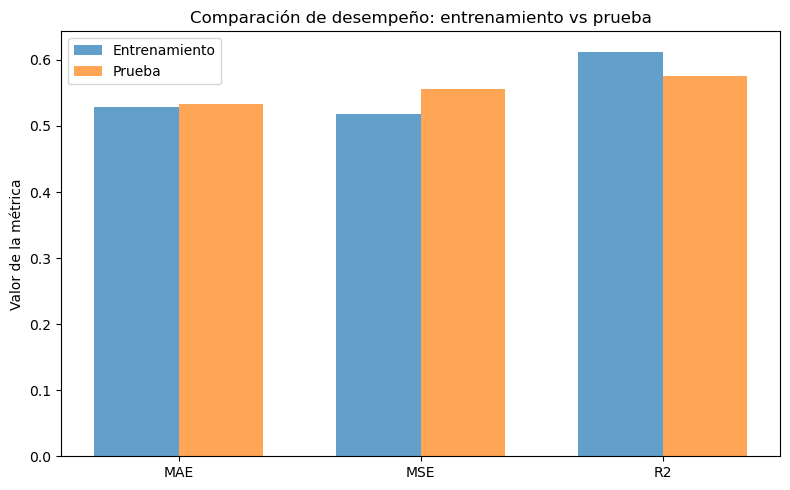

In [8]:
# División de los datos (80% entrenamiento (train), 20% prueba (test))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Tener una misma semilla aleatoria random_state garantiza que todos obtengamos el mismo resultado

model = LinearRegression() # 1. Instanciamos el modelo y sus hiperparámetros
model.fit(X_train, y_train)            # 2. Entrenamos el modelo con LOS DATOS DE ENTRENAMIENTO
y_pred_test = model.predict(X_test)  # 3. Hacemos predicciones con LOS DATOS DE PRUEBA

# Métricas de evaluación
# Se hacen con respecto a los DATOS DE PRUEBA
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("Evaluación del modelo en el conjunto de prueba:")
print(f"MAE: {mae_test:.3f}")
print(f"MSE: {mse_test:.3f}")
print(f"R2: {r2_test:.3f}")

## plot de comparación
y_pred_train = model.predict(X_train) # predicción y metricas usando los datos con los que fue entrando el modelo
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# etiquetas y valores para el plot
labels = ['MAE', 'MSE', 'R2']
train_scores = [mae_train, mse_train, r2_train]
test_scores = [mae_test, mse_test, r2_test]
x = range(len(labels)) # valores x del grafico
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, train_scores, width=width, label='Entrenamiento', alpha=0.7)
plt.bar([p + width for p in x], test_scores, width=width, label='Prueba', alpha=0.7)
plt.xticks([p + width / 2 for p in x], labels)
plt.ylabel('Valor de la métrica')
plt.title('Comparación de desempeño: entrenamiento vs prueba')
plt.legend()
plt.tight_layout()
plt.show()

Ahora que el modelo fue evaluado en un conjunto separado, observamos que el error aumenta ligeramente y el valor de $R^2$ disminuye respecto al caso anterior. Esto es normal y esperable: los resultados reflejan ahora el **desempeño realista** del modelo sobre datos nuevos.

Este tipo de evaluación es más honesta y nos permite saber qué tan bien generaliza nuestro modelo. Sin embargo, aún puede depender de cómo se haya dividido el conjunto. Para abordar esto de forma más robusta, exploraremos a continuación la técnica de **validación cruzada**.

## Validación cruzada: evaluación más robusta del modelo

Dividir los datos una sola vez en entrenamiento y prueba puede introducir **variabilidad** en los resultados, especialmente si el conjunto de datos es pequeño o heterogéneo. Una forma más confiable de estimar el rendimiento de un modelo es mediante la **validación cruzada**.

### ¿Qué es la validación cruzada?

La idea central es repetir el proceso de entrenamiento y evaluación varias veces, con diferentes particiones de los datos, y luego promediar los resultados.

<div style="text-align:center">
<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/250px-K-fold_cross_validation_EN.svg.png />
</div>

El enfoque más común es la **validación cruzada k-fold**, que funciona así:

1. Se divide el conjunto de datos en `k` partes (o *folds*) del mismo tamaño.
2. En cada iteración, se entrena el modelo con `k-1` partes y se evalúa en la parte restante.
3. Se repite este proceso `k` veces, rotando el fold de evaluación.
4. Finalmente, se calcula el **promedio y la desviación estándar** de las métricas obtenidas.

Este método reduce el sesgo de la división aleatoria y nos da una mejor idea del comportamiento general del modelo.

A continuación aplicaremos validación cruzada al modelo de regresión lineal que venimos utilizando.


In [9]:
# Validación cruzada con k=10
cv_scores = cross_val_score(model, X, y, cv=10, scoring='r2') # la validación se tiene que basar en un score, en este caso r2, pero puede ser otro

# Resultados por fold
print("R2 por fold:", cv_scores)
print(f"R2 promedio: {cv_scores.mean():.3f}")
print(f"Desviación estándar: {cv_scores.std():.3f}")

R2 por fold: [0.48254494 0.61416063 0.42274892 0.48178521 0.55705986 0.5412919
 0.47496038 0.45844938 0.48177943 0.59528796]
R2 promedio: 0.511
Desviación estándar: 0.059


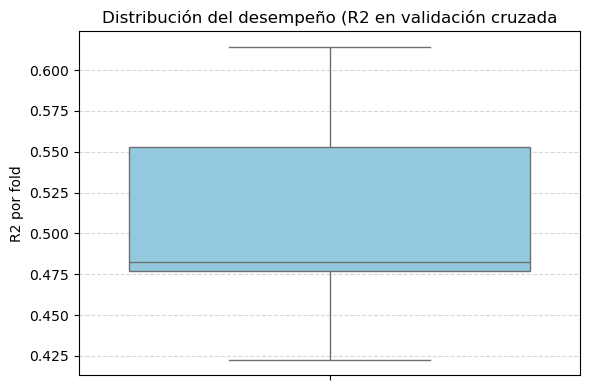

In [10]:
# Comparación gráfica

# Crear un DataFrame para graficar
cv_df = pd.DataFrame(cv_scores, columns=["R2"])

# Boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(data=cv_df, y="R2", color="skyblue")
plt.title("Distribución del desempeño (R2 en validación cruzada")
plt.ylabel("R2 por fold")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Con la validación cruzada obtenemos una estimación más robusta del rendimiento del modelo. En este caso, observamos que el valor promedio de $R^2$ es similar al obtenido con el conjunto de prueba, pero con la ventaja adicional de estar basado en múltiples particiones, lo que lo hace más confiable.

Además, la desviación estándar nos indica **qué tanto varía el desempeño del modelo** entre los distintos folds. Si la variación es muy alta, puede ser señal de que el modelo es inestable o muy sensible a los datos.

Como se observa en el boxplot, el desempeño del modelo de regresión lineal varía ligeramente entre los distintos folds, pero se mantiene dentro de un rango razonable. Esta estabilidad sugiere que el modelo generaliza de forma consistente sobre diferentes subconjuntos del dataset.

Este tipo de análisis es muy útil para **detectar modelos inestables** y para comparar diferentes algoritmos en condiciones similares, como haremos más adelante con modelos regularizados como Ridge y Lasso.

## Resumen y conclusiones

En este notebook aprendiste que **evaluar un modelo de forma adecuada** es tan importante como construirlo. A lo largo de este ejercicio vimos cómo distintas estrategias de evaluación pueden llevar a interpretaciones muy distintas sobre el rendimiento de un modelo.

- Cuando entrenamos y evaluamos sobre el **mismo conjunto de datos**, los resultados a veces son engañosamente buenos. Esta situación refleja un caso típico de **sobreajuste**.
- Al usar una **división entre entrenamiento y prueba**, obtenemos una visión más realista del comportamiento del modelo ante datos nuevos.
- Finalmente, la **validación cruzada** nos permitió estimar el desempeño del modelo de forma más robusta, al evaluar múltiples particiones del dataset.

Estas herramientas son esenciales para cualquier análisis predictivo serio, ya que nos permiten evitar falsas expectativas sobre el rendimiento de nuestros modelos y tomar mejores decisiones.

En la siguiente unidad abordaremos una problemática común en modelos lineales: la **presencia de muchas variables o variables correlacionadas**, que pueden amplificar el sobreajuste. Para resolver esto, introduciremos técnicas de **regularización** como **Ridge** y **Lasso**, que permiten mejorar la generalización del modelo y, en el caso de Lasso, también seleccionar automáticamente las variables más relevantes.

---
